In [1]:
from __future__ import absolute_import, division, print_function
#
import tensorflow as tf
#
from tensorflow.keras.layers import Input, Dense, Activation,  LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
# 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_shape = (28*28,) # 784
intermediate_dim_1 = 128
intermediate_dim_2 = 64
intermediate_dim_3 = 32
intermediate_dim_4 = 16
latent_dim = 2 
    
# Train parameters
epochs = 3
batch_size=64

In [3]:
inputs = Input(shape=input_shape,name='encoder_input')
x = Activation('relu')(inputs)
x = Dense(intermediate_dim_1, name='hidden_layer_1_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_2, name='hidden_layer_2_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_3, name='hidden_layer_3_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_4, name='hidden_layer_4_e')(x)
x = Activation('relu')(x)
outputs = Dense(latent_dim, name='latent_space')(x)
#outputs = LayerNormalization(axis=1)(x)

encoder = Model(inputs=inputs, outputs=outputs, name='dense_encoder')

encoder.summary()

Model: "dense_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
activation (Activation)      (None, 784)               0         
_________________________________________________________________
hidden_layer_1_e (Dense)     (None, 128)               100480    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
hidden_layer_2_e (Dense)     (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
hidden_layer_3_e (Dense)     (None, 32)              

In [4]:
latent_input = Input(shape = (latent_dim,), name='decoder_input')
x = Activation('relu')(latent_input)
x = Dense(intermediate_dim_4 , name='hidden_layer_de_4_d')(latent_input)
x = Activation('relu')(x)
x = Dense(intermediate_dim_3 , name='hidden_layer_de_3_d')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_2 , name='hidden_layer_de_2_d')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_1 , name='hidden_layer_de_1_d')(x)
x = Activation('relu')(x)
x = Dense(input_shape[0], name='original_space')(x)
x = Activation('sigmoid')(x)

decoder = Model (inputs=latent_input, outputs=x, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
hidden_layer_de_4_d (Dense)  (None, 16)                48        
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
hidden_layer_de_3_d (Dense)  (None, 32)                544       
_________________________________________________________________
activation_7 (Activation)    (None, 32)                0         
_________________________________________________________________
hidden_layer_de_2_d (Dense)  (None, 64)                2112      
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0   

In [5]:
# Autoencoder Model
autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)),
                    name='autoencoder_mnist_model')

#Summary
autoencoder.summary()

Model: "autoencoder_mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
dense_encoder (Functional)   (None, 2)                 111378    
_________________________________________________________________
decoder (Functional)         (None, 784)               112160    
Total params: 223,538
Trainable params: 223,538
Non-trainable params: 0
_________________________________________________________________


In [6]:
optimizer = Adam(learning_rate=1e-3)
loss_fn = MeanSquaredError()
autoencoder.compile(optimizer= optimizer, loss = loss_fn)

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

epochs = 20
batch_size = 64


In [8]:
# Train
history = autoencoder.fit(x_train, x_train, epochs = epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
844/844 [==============================] - 3s 3ms/step - loss: 0.0618 - val_loss: 0.0491
Epoch 2/20
844/844 [==============================] - 3s 3ms/step - loss: 0.0475 - val_loss: 0.0449
Epoch 3/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0446 - val_loss: 0.0428
Epoch 4/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0429 - val_loss: 0.0414
Epoch 5/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0416 - val_loss: 0.0403
Epoch 6/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0408 - val_loss: 0.0398
Epoch 7/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0400 - val_loss: 0.0389
Epoch 8/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0394 - val_loss: 0.0386
Epoch 9/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0390 - val_loss: 0.0381
Epoch 10/20
844/844 [==============================] - 2s 3ms/step - loss: 0.0386 - val_loss: 0.0375

In [9]:
autoencoder.evaluate(x_test,x_test) # 0.0361
autoencoder.evaluate(x_train,x_train) # 0.0358

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0361


0.03614749014377594

In [10]:
def reconstruction_image(img_original, img_decoded, image_size=28, num_images=8, random=True, file_name=None):
    
    # control number of images, maximum is  16. 
    if num_images > 16:
        num_images = 16
    
    # select images
    if random:
        shape_0 = img_original.shape[0]
        index = np.random.randint(low=0, high=shape_0, size=num_images)
    else:
        index = range(num_images) # first images
    
    # prepare data
    imgs = np.concatenate([img_original[index], img_decoded[index]])
    imgs = imgs.reshape((2, num_images, image_size, image_size))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    
    # plot
    plt.axis('off')
    plt.title('Input: First row, Decoded: Second row')
    plt.imshow(1-imgs, interpolation='none', cmap='gray')
    if file_name is not None:
        plt.savefig(file_name)
    plt.show()

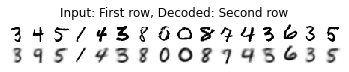

In [11]:

reconstruction_image(img_original= x_test, img_decoded=autoencoder.predict(x_test), 
                         image_size=28, num_images= 20, random=True)

In [15]:
def plot2D(x_latent, y_label,
           sample_percent = 100, #show 100% by default
           xmin=-4.0, ymin=-4.0,
           xmax=4.0,  ymax=4.0,
           filename=None,
           xlabel='Dim 1',
           ylabel='Dim 2',
           title='Latent Space-2D'):
    
    
    # select sample to reduce the data
    if sample_percent>=100:
        sample_percent= 100
    elif sample_percent<=0:
        sample_percent= 10
    if sample_percent!=100:
        shape_0 = x_latent.shape[0]
        size = int(shape_0*sample_percent/100)
        index = index = np.random.randint(low=0, high=shape_0, size=size)
        z = x_latent[index]
        y_test = y_label[index]
    else:
        z = x_latent
        y_test = y_label
    
    
    # configure the plot
    #fig, ax = plt.subplots(figsize=(20, 16))
    fig = plt.figure(figsize=(40, 30))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel,fontsize=12)
    ax.set_title(title,fontsize=15)
    ax.grid(True)
    
    # plot
    #plt.scatter(z[:, 0], z[:, 1], marker="")
    ax.scatter(z[:, 0], z[:, 1], c=y_label ,alpha=0.1, edgecolors='none')
    for i, digit in enumerate(y_test):
        ax.annotate(digit, (z[i, 0], z[i, 1]))
   
    # save the plot
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [16]:
x_train_latent = encoder(x_train)
x_train_latent = x_train_latent.numpy()

x_test_latent = encoder(x_test)
x_test_latent = x_test_latent.numpy()


In [17]:
plot2D(x_test_latent[0::2], y_test[0::2])